In [1]:
from tensorflow import keras
from tensorflow.keras import layers

2023-03-03 00:12:44.107954: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-03 00:12:44.238426: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-03 00:12:44.700269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-03 00:12:44.700333: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

In [4]:
def build_model(input_shape,head_size, num_heads,ff_dim,num_transformer_blocks,mlp_units,dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [2]:
import numpy as np

In [3]:
data = np.load('train_test_x_y.npz')
train_x, test_x, train_y, test_y  = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'] 

In [4]:
train_y = train_y.reshape(-1,1)
test_y  = test_y.reshape(-1,1)

In [5]:
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((18390, 48, 26), (4598, 48, 26), (18390, 1), (4598, 1))

In [9]:
input_shape = train_x.shape[1:]

In [10]:
input_shape

(48, 26)

In [11]:
n_classes = len(np.unique(train_y))

In [12]:
n_classes

2

In [15]:
model = build_model(input_shape,head_size=16,num_heads=2,ff_dim=4,num_transformer_blocks=4,mlp_units=[32],mlp_dropout=0.25,dropout=0.25)


2023-02-24 13:08:36.235398: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:08:37.152985: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:08:37.153745: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-24 13:08:37.164020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
from utils_window import f1_m

In [17]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_m], weighted_metrics=[])

In [18]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

In [19]:
train_history=model.fit(train_x,train_y,validation_split=0.2, epochs=50,batch_size=64,callbacks=callbacks)

Epoch 1/50


2023-02-24 13:10:10.787101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


230/230 [==============================] - 33s 34ms/step - loss: 0.3269 - accuracy: 0.8927 - f1_m: 0.0236 - val_loss: 0.3048 - val_accuracy: 0.8967 - val_f1_m: 0.0000e+00
Epoch 2/50
230/230 [==============================] - 5s 21ms/step - loss: 0.2903 - accuracy: 0.9008 - f1_m: 0.0211 - val_loss: 0.2969 - val_accuracy: 0.8967 - val_f1_m: 0.0000e+00
Epoch 3/50
230/230 [==============================] - 3s 15ms/step - loss: 0.2851 - accuracy: 0.9013 - f1_m: 0.0261 - val_loss: 0.2871 - val_accuracy: 0.8975 - val_f1_m: 0.0107
Epoch 4/50
230/230 [==============================] - 3s 13ms/step - loss: 0.2779 - accuracy: 0.9017 - f1_m: 0.0346 - val_loss: 0.2979 - val_accuracy: 0.8980 - val_f1_m: 0.0213
Epoch 5/50
230/230 [==============================] - 3s 12ms/step - loss: 0.2721 - accuracy: 0.9028 - f1_m: 0.0840 - val_loss: 0.2808 - val_accuracy: 0.8989 - val_f1_m: 0.0577
Epoch 6/50
230/230 [==============================] - 4s 16ms/step - loss: 0.2676 - accuracy: 0.9042 - f1_m: 0.1153 -

In [7]:
# model.save('mimic3_ts_transformer_attention_extraction.h5')

In [6]:
### load keras model
from tensorflow import keras

model = keras.models.load_model('mimic3_ts_transformer_attention_extraction.h5', compile=False)

2023-03-03 00:13:02.389156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 00:13:02.414353: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 00:13:02.414523: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-03 00:13:02.414924: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, matthews_corrcoef

In [8]:
print(roc_auc_score(test_y, model.predict(test_x)))
print(average_precision_score(test_y, model.predict(test_x)))
print(f1_score(test_y, np.round(model.predict(test_x))))
print(recall_score(test_y, np.round(model.predict(test_x))))
print(precision_score(test_y, np.round(model.predict(test_x))))

2023-03-03 00:13:07.582681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8500


144/144 [==============================] - 1s 3ms/step
0.6283758411914857
144/144 [==============================] - 0s 3ms/step
0.1873645715459928
144/144 [==============================] - 0s 3ms/step
0.14617940199335547
144/144 [==============================] - 0s 3ms/step
0.09606986899563319
144/144 [==============================] - 0s 3ms/step
0.3055555555555556


In [9]:
matthews_corrcoef(test_y, np.round(model.predict(test_x)))

144/144 [==============================] - 0s 3ms/step


0.1236510277958226

In [10]:
############# extraction of attention from the first layer
#### model architecture

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 26)]     0           []                               
                                                                                                  
 layer_normalization (LayerNorm  (None, 48, 26)      52          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 multi_head_attention (MultiHea  (None, 48, 26)      3450        ['layer_normalization[0][0]',    
 dAttention)                                                      'layer_normalization[0][0]']    
                                                                                              

In [12]:
# keras.utils.plot_model(model,to_file="model_22ndfebtransformer.png")

In [28]:
### layer is multi_head_attention, multi_head_attention_1, multi_head_attention_2, multi_head_attention_3

In [13]:
#### for multi_head_attention 
att_weights_MHA0 = keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention').output)

att_weights_MHA1 = keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention_1').output)

att_weights_MHA2 = keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention_2').output)

att_weights_MHA3 = keras.Model(inputs=model.input, outputs=model.get_layer('multi_head_attention_3').output)

In [14]:
att_weights_MHA0_output = att_weights_MHA0.predict(test_x)
att_weights_MHA1_output = att_weights_MHA1.predict(test_x)
att_weights_MHA2_output = att_weights_MHA2.predict(test_x)
att_weights_MHA3_output = att_weights_MHA3.predict(test_x)

144/144 [==============================] - 1s 2ms/step


In [15]:
att_weights_MHA0_output.shape
att_weights_MHA1_output.shape
att_weights_MHA2_output.shape
att_weights_MHA3_output.shape

(4598, 48, 26)

In [85]:
# from sklearn.preprocessing import MinMaxScaler

# mms = MinMaxScaler()


# norm_att_weights_MHA0_output = mms.fit_transform(att_weights_MHA0_output)

# norm_att_weights_MHA1_output = mms.fit_transform(att_weights_MHA1_output)

# norm_att_weights_MHA2_output = mms.fit_transform(att_weights_MHA2_output)

# norm_att_weights_MHA3_output = mms.fit_transform(att_weights_MHA3_output)

In [40]:
######## use of these attention weights into windowSHAP.

In [16]:
##### parameters for some stuff (rewrite it later)
num_background = 15
num_test = index = 0
# background_ts, test_ts = train_x[:num_background], test_x[index:index + 17]
# background_data, test_data = train_x[:num_background], test_x[index:index + 17]

In [17]:
from util import heat_map

In [18]:
var = 1
phi_index = 3

In [19]:
test_x[num_test + phi_index, :, var].shape, att_weights_MHA0_output[phi_index, :, var].shape

((48,), (48,))

[-0.85750926 -0.85250926 -0.84750926 -0.84250926 -0.83750926 -0.83250926
 -0.82750926 -0.82250926 -0.81750926 -0.81250926 -0.80750926 -0.80250926
 -0.79750926 -0.79250926 -0.78750926 -0.78250926 -0.77750926 -0.77250926
 -0.76750926 -0.76250926 -0.75750926 -0.75250926 -0.74750926 -0.74250926
 -0.73750926 -0.73250926 -0.72750926 -0.72250926 -0.71750926 -0.71250926
 -0.70750926  0.        ]


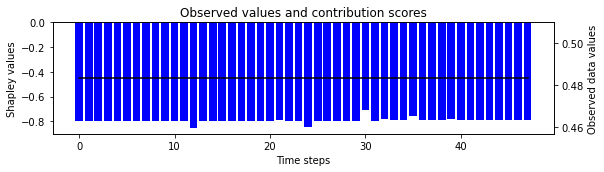

In [20]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_weights_MHA0_output[phi_index, :, var], var_name='Observed', plot_type='bar')

[-0.7854495 -0.7804495 -0.7754495  0.       ]


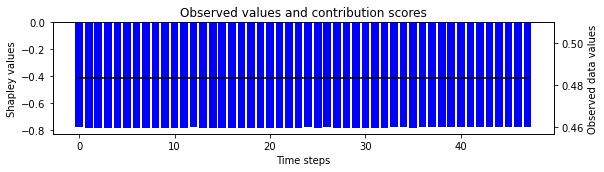

In [21]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_weights_MHA1_output[phi_index, :, var], var_name='Observed', plot_type='bar')

[0.         0.70565498 0.71065498]


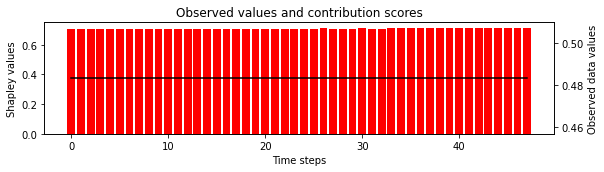

In [22]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_weights_MHA2_output[phi_index, :, var], var_name='Observed', plot_type='bar')

[0.         0.82128757]


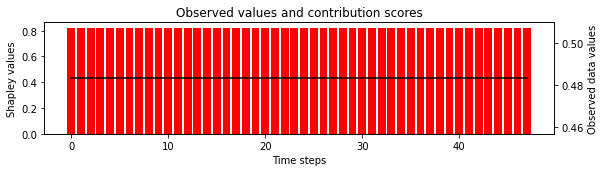

In [23]:
heat_map(start=0, stop=48, x=test_x[num_test + phi_index, :, var], shap_values=att_weights_MHA3_output[phi_index, :, var], var_name='Observed', plot_type='bar')

In [24]:
model, att_weights_MHA0_output.shape, att_weights_MHA1_output.shape, att_weights_MHA2_output.shape, att_weights_MHA3_output.shape,test_x.shape 

(<keras.engine.functional.Functional at 0x7f254f5f1b20>,
 (4598, 48, 26),
 (4598, 48, 26),
 (4598, 48, 26),
 (4598, 48, 26),
 (4598, 48, 26))

In [27]:
from util import heat_map, xai_eval_fnc

In [25]:
######### model prediction
y_pred_orig = model.predict(test_x)

144/144 [==============================] - 0s 3ms/step


In [29]:
#xai_eval_fnc(model, relevence, input_x)
xai_res_prtb_mha1 = xai_eval_fnc(model, att_weights_MHA0_output, test_x, eval_type='prtb')

xai_res_prtb_mha2 = xai_eval_fnc(model, att_weights_MHA1_output, test_x, eval_type='prtb')

xai_res_prtb_mha3 = xai_eval_fnc(model, att_weights_MHA2_output, test_x, eval_type='prtb')

xai_res_prtb_mha4 = xai_eval_fnc(model, att_weights_MHA3_output, test_x, eval_type='prtb')

144/144 [==============================] - 0s 3ms/step


In [32]:
seq_len_val  = 48


xai_res_sqnc_mha1 = xai_eval_fnc(model, att_weights_MHA0_output, test_x, eval_type='sqnc',seq_len=seq_len_val)

xai_res_sqnc_mha2 = xai_eval_fnc(model, att_weights_MHA1_output, test_x, eval_type='sqnc',seq_len=seq_len_val)

xai_res_sqnc_mha3 = xai_eval_fnc(model, att_weights_MHA2_output, test_x, eval_type='sqnc',seq_len=seq_len_val)

xai_res_sqnc_mha4 = xai_eval_fnc(model, att_weights_MHA3_output, test_x, eval_type='sqnc',seq_len=seq_len_val)

144/144 [==============================] - 0s 3ms/step


In [31]:
xai_res_prtb_mha1.shape,xai_res_prtb_mha2.shape,xai_res_prtb_mha3.shape, xai_res_prtb_mha4.shape

((4598, 1), (4598, 1), (4598, 1), (4598, 1))

In [33]:
xai_res_sqnc_mha1.shape, xai_res_sqnc_mha2.shape, xai_res_sqnc_mha3.shape, xai_res_sqnc_mha4.shape

((4598, 1), (4598, 1), (4598, 1), (4598, 1))

In [34]:
################# original model prediction

print('original_model_predictions: ',roc_auc_score(test_y, y_pred_orig), average_precision_score(test_y, y_pred_orig),f1_score(test_y, np.round(y_pred_orig)),
      recall_score(test_y, np.round(y_pred_orig)),precision_score(test_y, np.round(y_pred_orig)),matthews_corrcoef(test_y, np.round(y_pred_orig)))

original_model_predictions:  0.6283758411914857 0.1873645715459928 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226


In [38]:
print('prtb_analysis_wshap_tsphi1: ',roc_auc_score(test_y, xai_res_prtb_mha1), average_precision_score(test_y, xai_res_prtb_mha1),f1_score(test_y, np.round(xai_res_prtb_mha1)),
      recall_score(test_y, np.round(xai_res_prtb_mha1)),precision_score(test_y, np.round(xai_res_prtb_mha1)),matthews_corrcoef(test_y, np.round(xai_res_prtb_mha1)))

print('prtb_analysis_wshap_tsphi2: ',roc_auc_score(test_y, xai_res_prtb_mha2), average_precision_score(test_y, xai_res_prtb_mha2),f1_score(test_y, np.round(xai_res_prtb_mha2)),
      recall_score(test_y, np.round(xai_res_prtb_mha2)),precision_score(test_y, np.round(xai_res_prtb_mha2)),matthews_corrcoef(test_y, np.round(xai_res_prtb_mha2)))

print('prtb_analysis_wshap_tsphi3: ',roc_auc_score(test_y, xai_res_prtb_mha3), average_precision_score(test_y, xai_res_prtb_mha3),f1_score(test_y, np.round(xai_res_prtb_mha3)),
      recall_score(test_y, np.round(xai_res_prtb_mha3)),precision_score(test_y, np.round(xai_res_prtb_mha3)),matthews_corrcoef(test_y, np.round(xai_res_prtb_mha3)))

print('prtb_analysis_wshap_tsphi4: ',roc_auc_score(test_y, xai_res_prtb_mha4), average_precision_score(test_y, xai_res_prtb_mha4),f1_score(test_y, np.round(xai_res_prtb_mha4)),
      recall_score(test_y, np.round(xai_res_prtb_mha4)),precision_score(test_y, np.round(xai_res_prtb_mha4)),matthews_corrcoef(test_y, np.round(xai_res_prtb_mha4)))

prtb_analysis_wshap_tsphi1:  0.6283758411914857 0.1873645715459928 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
prtb_analysis_wshap_tsphi2:  0.6283742590131427 0.18736438785664097 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
prtb_analysis_wshap_tsphi3:  0.6283494715524334 0.18736071180203526 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
prtb_analysis_wshap_tsphi3:  0.6283790055481722 0.18736491669285443 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226


In [39]:
print('sqnc_analysis_wshap_tsphi1: ',roc_auc_score(test_y, xai_res_sqnc_mha1), average_precision_score(test_y, xai_res_sqnc_mha1),f1_score(test_y, np.round(xai_res_sqnc_mha1)),
      recall_score(test_y, np.round(xai_res_sqnc_mha1)),precision_score(test_y, np.round(xai_res_sqnc_mha1)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_mha1)))

print('sqnc_analysis_wshap_tsphi2: ',roc_auc_score(test_y, xai_res_sqnc_mha2), average_precision_score(test_y, xai_res_sqnc_mha2),f1_score(test_y, np.round(xai_res_sqnc_mha2)),
      recall_score(test_y, np.round(xai_res_sqnc_mha2)),precision_score(test_y, np.round(xai_res_sqnc_mha2)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_mha2)))

print('sqnc_analysis_wshap_tsphi3: ',roc_auc_score(test_y, xai_res_sqnc_mha3), average_precision_score(test_y, xai_res_sqnc_mha3),f1_score(test_y, np.round(xai_res_sqnc_mha3)),
      recall_score(test_y, np.round(xai_res_sqnc_mha3)),precision_score(test_y, np.round(xai_res_sqnc_mha3)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_mha3)))

print('sqnc_analysis_wshap_tsphi4: ',roc_auc_score(test_y, xai_res_sqnc_mha4), average_precision_score(test_y, xai_res_sqnc_mha4),f1_score(test_y, np.round(xai_res_sqnc_mha4)),
      recall_score(test_y, np.round(xai_res_sqnc_mha4)),precision_score(test_y, np.round(xai_res_sqnc_mha4)),matthews_corrcoef(test_y, np.round(xai_res_sqnc_mha4)))

sqnc_analysis_wshap_tsphi1:  0.6283758411914857 0.1873645715459928 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
sqnc_analysis_wshap_tsphi2:  0.6283906081893551 0.1873660832148795 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
sqnc_analysis_wshap_tsphi3:  0.6283600194080543 0.18736285793151886 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226
sqnc_analysis_wshap_tsphi4:  0.6283790055481722 0.18736491796896595 0.14617940199335547 0.09606986899563319 0.3055555555555556 0.1236510277958226


In [53]:
########################### lets pick the starting n
pick = 100

In [54]:
################# original model prediction

print('original_model_predictions: ',roc_auc_score(test_y[:pick], y_pred_orig[:pick]), average_precision_score(test_y[:pick], y_pred_orig[:pick]),f1_score(test_y[:pick], np.round(y_pred_orig[:pick])),
      recall_score(test_y[:pick], np.round(y_pred_orig[:pick])),precision_score(test_y[:pick], np.round(y_pred_orig[:pick])),matthews_corrcoef(test_y[:pick], np.round(y_pred_orig[:pick])))

original_model_predictions:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011


In [55]:
print('prtb_analysis_wshap_tsphi1: ',roc_auc_score(test_y[:pick], xai_res_prtb_mha1[:pick]), average_precision_score(test_y[:pick], xai_res_prtb_mha1[:pick]),f1_score(test_y[:pick], np.round(xai_res_prtb_mha1[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_prtb_mha1[:pick])),precision_score(test_y[:pick], np.round(xai_res_prtb_mha1[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_prtb_mha1[:pick])))

print('prtb_analysis_wshap_tsphi2: ',roc_auc_score(test_y[:pick], xai_res_prtb_mha2[:pick]), average_precision_score(test_y[:pick], xai_res_prtb_mha2[:pick]),f1_score(test_y[:pick], np.round(xai_res_prtb_mha2[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_prtb_mha2[:pick])),precision_score(test_y[:pick], np.round(xai_res_prtb_mha2[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_prtb_mha2[:pick])))

print('prtb_analysis_wshap_tsphi3: ',roc_auc_score(test_y[:pick], xai_res_prtb_mha3[:pick]), average_precision_score(test_y[:pick], xai_res_prtb_mha3[:pick]),f1_score(test_y[:pick], np.round(xai_res_prtb_mha3[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_prtb_mha3[:pick])),precision_score(test_y[:pick], np.round(xai_res_prtb_mha3[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_prtb_mha3[:pick])))

print('prtb_analysis_wshap_tsphi4: ',roc_auc_score(test_y[:pick], xai_res_prtb_mha4[:pick]), average_precision_score(test_y[:pick], xai_res_prtb_mha4[:pick]),f1_score(test_y[:pick], np.round(xai_res_prtb_mha4[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_prtb_mha4[:pick])),precision_score(test_y[:pick], np.round(xai_res_prtb_mha4[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_prtb_mha4[:pick])))

prtb_analysis_wshap_tsphi1:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
prtb_analysis_wshap_tsphi2:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
prtb_analysis_wshap_tsphi3:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
prtb_analysis_wshap_tsphi4:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011


In [56]:
print('sqnc_analysis_wshap_tsphi1: ',roc_auc_score(test_y[:pick], xai_res_sqnc_mha1[:pick]), average_precision_score(test_y[:pick], xai_res_sqnc_mha1[:pick]),f1_score(test_y[:pick], np.round(xai_res_sqnc_mha1[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_sqnc_mha1[:pick])),precision_score(test_y[:pick], np.round(xai_res_sqnc_mha1[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_sqnc_mha1[:pick])))

print('sqnc_analysis_wshap_tsphi2: ',roc_auc_score(test_y[:pick], xai_res_sqnc_mha2[:pick]), average_precision_score(test_y[:pick], xai_res_sqnc_mha2[:pick]),f1_score(test_y[:pick], np.round(xai_res_sqnc_mha2[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_sqnc_mha2[:pick])),precision_score(test_y[:pick], np.round(xai_res_sqnc_mha2[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_sqnc_mha2[:pick])))

print('sqnc_analysis_wshap_tsphi3: ',roc_auc_score(test_y[:pick], xai_res_sqnc_mha3[:pick]), average_precision_score(test_y[:pick], xai_res_sqnc_mha3[:pick]),f1_score(test_y[:pick], np.round(xai_res_sqnc_mha3[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_sqnc_mha3[:pick])),precision_score(test_y[:pick], np.round(xai_res_sqnc_mha3[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_sqnc_mha3[:pick])))

print('sqnc_analysis_wshap_tsphi4: ',roc_auc_score(test_y[:pick], xai_res_sqnc_mha4[:pick]), average_precision_score(test_y[:pick], xai_res_sqnc_mha4[:pick]),f1_score(test_y[:pick], np.round(xai_res_sqnc_mha4[:pick])),
      recall_score(test_y[:pick], np.round(xai_res_sqnc_mha4[:pick])),precision_score(test_y[:pick], np.round(xai_res_sqnc_mha4[:pick])),matthews_corrcoef(test_y[:pick], np.round(xai_res_sqnc_mha4[:pick])))

sqnc_analysis_wshap_tsphi1:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
sqnc_analysis_wshap_tsphi2:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
sqnc_analysis_wshap_tsphi3:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011
sqnc_analysis_wshap_tsphi4:  0.6178266178266179 0.13343144824216485 0.15384615384615383 0.1111111111111111 0.25 0.11412279800291011


In [60]:
############################# comparing losses
### function

import tensorflow.keras.backend as K
def BinaryCrossEntropy(y_true, y_pred): 
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    term_0 = (1 - y_true) * K.log(1 - y_pred + K.epsilon())  
    term_1 = y_true * K.log(y_pred + K.epsilon())
    return -K.mean(term_0 + term_1, axis=0)


In [66]:
print('original_model_predictions: ',BinaryCrossEntropy(test_y, y_pred_orig))

original_model_predictions:  tf.Tensor([0.3845515], shape=(1,), dtype=float32)


In [67]:
print('prtb_analysis_wshap_tsphi1: ',BinaryCrossEntropy(test_y, xai_res_prtb_mha1))
      
print('prtb_analysis_wshap_tsphi2: ',BinaryCrossEntropy(test_y, xai_res_prtb_mha2))

print('prtb_analysis_wshap_tsphi3: ',BinaryCrossEntropy(test_y, xai_res_prtb_mha3))

print('prtb_analysis_wshap_tsphi4: ',BinaryCrossEntropy(test_y, xai_res_prtb_mha4))

prtb_analysis_wshap_tsphi1:  tf.Tensor([0.3845515], shape=(1,), dtype=float32)
prtb_analysis_wshap_tsphi2:  tf.Tensor([0.38455153], shape=(1,), dtype=float32)
prtb_analysis_wshap_tsphi3:  tf.Tensor([0.384555], shape=(1,), dtype=float32)
prtb_analysis_wshap_tsphi4:  tf.Tensor([0.38455126], shape=(1,), dtype=float32)


In [68]:
print('sqnc_analysis_wshap_tsphi1: ',BinaryCrossEntropy(test_y, xai_res_sqnc_mha1))
print('sqnc_analysis_wshap_tsphi2: ',BinaryCrossEntropy(test_y, xai_res_sqnc_mha2))
print('sqnc_analysis_wshap_tsphi3: ',BinaryCrossEntropy(test_y, xai_res_sqnc_mha3))
print('sqnc_analysis_wshap_tsphi4: ',BinaryCrossEntropy(test_y, xai_res_sqnc_mha4))

sqnc_analysis_wshap_tsphi1:  tf.Tensor([0.3845515], shape=(1,), dtype=float32)
sqnc_analysis_wshap_tsphi2:  tf.Tensor([0.384551], shape=(1,), dtype=float32)
sqnc_analysis_wshap_tsphi3:  tf.Tensor([0.3845523], shape=(1,), dtype=float32)
sqnc_analysis_wshap_tsphi4:  tf.Tensor([0.3845513], shape=(1,), dtype=float32)


In [ ]:
####### same pick level

